In [3]:
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from brainflow.board_shim import BoardShim, BrainFlowInputParams, LogLevels, BoardIds

from sklearn import tree
from sklearn import metrics
from sklearn.model_selection import train_test_split

In [23]:
board_id = BoardIds.CROWN_BOARD.value
params = BrainFlowInputParams()
params.mac_address = "C0:EE:40:84:DD:56"
params.serial_number = "58a99b0107e64cd40ea5e6607882cbe2"
params.board_id = board_id
params.timeout = 5
BoardShim.enable_dev_board_logger()
board = BoardShim(board_id, params)
board.prepare_session()

[2023-01-11 22:00:58.166] [board_logger] [info] incoming json: {
    "board_id": 23,
    "file": "",
    "file_anc": "",
    "file_aux": "",
    "ip_address": "",
    "ip_address_anc": "",
    "ip_address_aux": "",
    "ip_port": 0,
    "ip_port_anc": 0,
    "ip_port_aux": 0,
    "ip_protocol": 0,
    "mac_address": "C0:EE:40:84:DD:56",
    "master_board": -100,
    "other_info": "",
    "serial_number": "58a99b0107e64cd40ea5e6607882cbe2",
    "serial_port": "",
    "timeout": 5
}
[2023-01-11 22:00:58.166] [board_logger] [trace] Board object created 23
[2023-01-11 22:00:58.166] [board_logger] [debug] Use IP port 9000


In [153]:
inputs = []
outputs = []
BoardShim.disable_board_logger()
board.start_stream()
for i in range(9):
    print("Think Nothing")
    time.sleep(1)
    board.get_board_data()
    time.sleep(4)
    nothing = board.get_board_data()[1:9]
    
    print("Think Left")
    time.sleep(1)
    board.get_board_data()
    time.sleep(4)
    left = board.get_board_data()[1:9]

    print("Think Right")
    time.sleep(1)
    board.get_board_data()
    time.sleep(4)
    right = board.get_board_data()[1:9]
    
    inputs.append(nothing)
    inputs.append(left)
    inputs.append(right)
    outputs.append(1)
    outputs.append(0)
    outputs.append(2)
board.stop_stream()

Think Nothing
Think Left
Think Right
Think Nothing
Think Left
Think Right
Think Nothing
Think Left
Think Right
Think Nothing
Think Left
Think Right
Think Nothing
Think Left
Think Right
Think Nothing
Think Left
Think Right
Think Nothing
Think Left
Think Right
Think Nothing
Think Left
Think Right
Think Nothing
Think Left
Think Right


In [154]:
data = np.array([inputs, outputs], dtype=object)
np.save("raw_data.npy", data)

In [185]:
data = np.load("raw_data_5min.npy", allow_pickle=True)

In [188]:
inputs = []
targets = []
size = 32 * 2
for i, reading in enumerate(data[0]):
    length = reading.shape[1]
    excess = length % size
    # print(excess)
    # Cut off excess data
    if excess != 0:
        reading = reading[:,:-excess]
    length = reading.shape[1]
    
    # Split into smaller chunks for training
    split_reading = np.split(reading, length // size, axis=1)
    
    # Add to inputs and outputs
    for split in split_reading:
        inputs.append(split)
        targets.append(data[1][i])

targets = np.array(targets)
inputs = np.array(inputs)

# Average the data
inputs = ((inputs + np.roll(inputs, 1, axis=2)) / 2.0)[:,:,1::2]
inputs = np.average(inputs, axis=1)

In [189]:
print(inputs.shape)
print(targets.shape)

(1038, 32)
(1038,)


In [194]:
inputs_train, inputs_valid, targets_train, targets_valid = train_test_split(inputs, targets, test_size=0.3)

inputs_train = inputs_train.reshape(inputs_train.shape[0], -1)
inputs_valid = inputs_valid.reshape(inputs_valid.shape[0], -1)

model = tree.DecisionTreeClassifier()
model = model.fit(inputs_train, targets_train)

In [195]:
plt.style.use('seaborn-v0_8-white')

[2 1 0 0 2 1 1 2 2 0 0 0 2 1 2 0 2 1 2 0 2 1 1 2 1 2 0 1 0 1 0 0 1 1 0 2 1
 2 1 2 1 2 0 0 2 1 2 1 2 1 2 2 0 0 0 2 0 2 2 1 2 0 0 1 2 1 1 1 2 0 0 0 0 0
 2 2 2 0 1 0 0 1 0 2 0 0 0 0 2 2 2 2 0 2 0 1 1 1 2 0 1 0 0 0 2 0 0 0 1 1 0
 2 0 1 1 2 1 2 0 2 0 2 1 0 1 1 1 2 2 1 2 0 1 0 0 0 2 1 0 1 0 2 2 1 1 0 2 1
 2 1 1 2 1 0 2 0 1 2 0 2 1 2 1 2 2 1 1 1 1 2 0 2 0 1 2 0 0 2 2 1 2 2 0 2 2
 2 2 0 1 1 1 2 0 2 0 2 1 0 0 0 1 0 0 0 1 0 1 2 0 0 2 2 1 1 2 0 0 2 1 0 2 2
 0 0 2 1 2 0 0 1 0 1 0 2 0 1 0 0 1 0 0 0 0 0 1 0 2 1 0 2 1 1 0 1 1 1 2 1 0
 0 2 2 0 2 1 2 2 2 2 1 0 2 0 1 2 0 0 1 1 2 0 0 2 0 1 1 0 2 1 2 2 0 1 1 2 0
 1 0 0 0 1 2 2 1 1 0 2 2 1 0 0 1]
[2 1 0 0 2 1 1 2 2 0 0 0 2 1 2 1 2 1 2 0 2 1 1 0 1 2 0 1 0 2 0 0 1 1 0 2 2
 2 1 2 1 2 0 0 2 1 2 1 2 1 2 2 0 0 0 2 0 2 2 1 2 0 0 1 2 1 1 1 2 0 0 0 0 0
 2 2 2 0 1 0 0 1 0 2 0 0 0 0 2 2 0 2 0 2 0 1 1 1 2 0 1 0 0 0 2 0 0 0 1 1 0
 2 0 1 1 2 1 2 0 2 0 2 1 0 1 1 1 2 2 1 2 0 1 0 0 0 2 1 0 1 0 2 2 1 1 0 2 1
 2 1 1 2 1 0 2 0 1 2 0 2 1 2 1 2 2 1 1 1 1 2 0 2 0 1 2 0 0 2 2 1 2

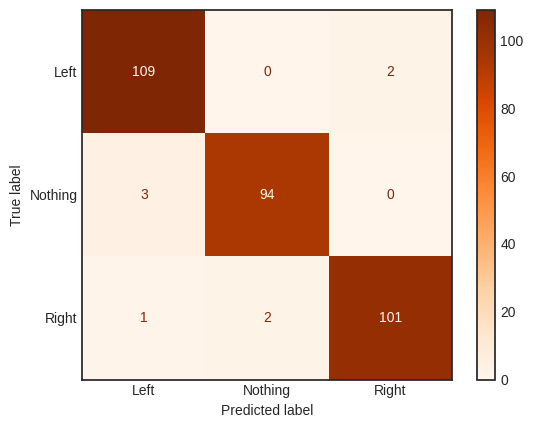

In [196]:
predictions = model.predict(inputs_valid)
print(predictions)
print(targets_valid)

accuracy = metrics.accuracy_score(targets_valid, model.predict(inputs_valid))
print(accuracy)

cm = metrics.confusion_matrix(targets_valid, model.predict(inputs_valid))
disp = metrics.ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Left', 'Nothing', 'Right'])
disp.plot(cmap=plt.cm.Oranges)
plt.show()

[Text(0.5763888888888888, 0.9545454545454546, 'X[6] <= -7827.81\ngini = 0.664\nsamples = 726\nvalue = [249, 263, 214]'),
 Text(0.3888888888888889, 0.8636363636363636, 'X[1] <= 687.66\ngini = 0.609\nsamples = 361\nvalue = [107, 67, 187]'),
 Text(0.2361111111111111, 0.7727272727272727, 'X[10] <= -13307.1\ngini = 0.593\nsamples = 208\nvalue = [106, 27, 75]'),
 Text(0.1388888888888889, 0.6818181818181818, 'X[8] <= -14069.785\ngini = 0.501\nsamples = 95\nvalue = [7, 27, 61]'),
 Text(0.08333333333333333, 0.5909090909090909, 'X[7] <= 3190.618\ngini = 0.517\nsamples = 46\nvalue = [2, 27, 17]'),
 Text(0.05555555555555555, 0.5, 'X[6] <= -11926.66\ngini = 0.128\nsamples = 29\nvalue = [2, 27, 0]'),
 Text(0.027777777777777776, 0.4090909090909091, 'gini = 0.0\nsamples = 27\nvalue = [0, 27, 0]'),
 Text(0.08333333333333333, 0.4090909090909091, 'gini = 0.0\nsamples = 2\nvalue = [2, 0, 0]'),
 Text(0.1111111111111111, 0.5, 'gini = 0.0\nsamples = 17\nvalue = [0, 0, 17]'),
 Text(0.19444444444444445, 0.5909

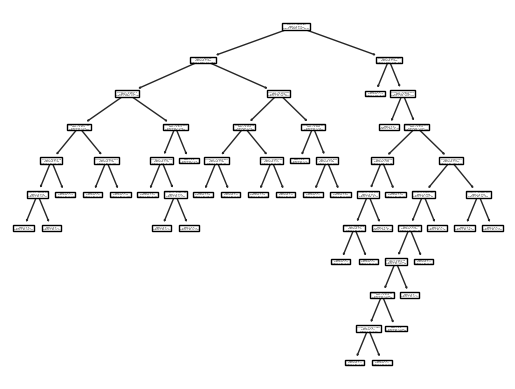

In [197]:
tree.plot_tree(model)

In [183]:
board.stop_stream()

In [198]:
board.start_stream()

start_time = time.time()
last_read = start_time
time.sleep(3)

realtime_raw_data = board.get_board_data()[1:9]

while start_time + 30 > time.time():
    realtime_raw_data = np.concatenate((realtime_raw_data, board.get_board_data()[1:9]), axis=1)[:,-size:]
    
    realtime_data = ((realtime_raw_data + np.roll(realtime_raw_data, 1, axis=1)) / 2.0)[:,1::2]
    realtime_data = np.average(realtime_data, axis=0)
    
    if time.time() > last_read + 0.5:
        predictions = model.predict(np.expand_dims(realtime_data.flatten(), axis=0))
        last_read = time.time()
        print(['Left', 'Nothing', 'Right'][predictions[0]])
    
    time.sleep(0.1)

board.stop_stream()

Nothing
Nothing
Nothing
Nothing
Nothing
Nothing
Nothing
Nothing
Right
Nothing
Nothing
Nothing
Nothing
Nothing
Nothing
Nothing
Nothing
Nothing
Nothing
Nothing
Nothing
Nothing
Nothing
Nothing
Nothing
Nothing
Nothing
Nothing


KeyboardInterrupt: 